<a href="https://colab.research.google.com/github/cheind/projective_circles/blob/main/projective-circles-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projective Circles

Demonstrates how circles and in particular circle centers transform under projective mappings. The notebook also highlights deviations from centroid detection in pixels and the true projected circle center.

Christoph Heindl, 2020

## References
[Projective Geometry](https://www.uio.no/studier/emner/matnat/its/nedlagte-emner/UNIK4690/v17/forelesninger/lecture_1_3_basic_projective_geometry_%282017%29.pdf)




In [143]:
!pip install -U matplotlib numpy transformations --quiet

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import transformations as T
from typing import Tuple

Core methods

In [145]:
def h(x: np.ndarray, v: float = 1.0):
    """Make NxD coordinates homogeneous Nx(D+1)"""
    N = x.shape[:-1]
    return np.concatenate((x, np.ones(N + (1,)) * v), -1)


def dh(x: np.ndarray):
    """Homogeneous (NxD+1) to inhomogeneous (NxD) transform."""
    N, D = x.shape[:-1], x.shape[-1]
    mask = x[..., -1] != 0.0
    xd = np.zeros(N + (D - 1,))
    xd[mask] = x[mask, :-1] / x[mask, -1:]
    xd[~mask] = x[~mask, : (D - 1)]
    return xd


def compute_H(t_cam_plane: np.ndarray, K: np.ndarray):
    """Returns the homography that maps plane coords to image coords.
    See central projection homography.
    """
    t = t_cam_plane[:3, -1]
    x, y = t_cam_plane[:3, [0, 1]].T
    return K @ np.eye(3) @ np.array([x, y, t]).T


def xy_on_circle(n: int = 200):
    """Returns xy coordinates on a unit circle."""
    t = np.linspace(0, 2 * np.pi, n)
    return np.stack((np.cos(t), np.sin(t)), -1)


def render_circle_image(
    t_cam_plane: np.ndarray, K: np.ndarray, shape: Tuple[int, int], radius: float = 2.0
) -> Tuple[np.ndarray, np.ndarray]:
    """Returns intensity and depth image of circle projection."""
    height, width = shape
    xy_cam = np.stack(np.meshgrid(range(width), range(height)), -1).reshape(-1, 2)
    H = compute_H(t_cam_plane, K)
    xy_plane = dh(h(xy_cam) @ np.linalg.inv(H).T)
    xy_plane = xy_plane.reshape(height, width, 2)
    dists = ((xy_plane) ** 2).sum(-1)
    mask = dists <= radius ** 2

    img = np.zeros((height, width))
    img[mask] = 1

    # Get pixels mapped to plane as 3D coords in cam
    xyz_plane = h(xy_plane, v=0.0)
    xyz_cam = dh(h(xyz_plane, v=1.0) @ t_cam_plane.T)

    depth = np.zeros((height, width))
    depth[mask] = xyz_cam[mask, -1]

    return img, depth

Main routine to compute results

In [146]:
def compute_circle_metrics(
    t_cam_plane: np.ndarray,
    K: np.ndarray,
    image_shape: Tuple[int, int],
    circle_radius: float,
    plot: bool = True,
    filename: str = "plot.png",
    show: bool = True,
) -> float:
    # Projetive mapping of plane to 'pixel' plane
    H = compute_H(t_cam_plane, K)

    circle_intensity, circle_depths = render_circle_image(
        t_cam_plane, K, image_shape, circle_radius
    )

    if circle_depths.max() <= 0:
        print("circle not visible.")
        return None, None

    # Circle points in plane
    xy_plane = xy_on_circle(200) * circle_radius
    # Same points in projection
    xy_cam = dh(h(xy_plane) @ H.T)

    # Correct circle center projection
    center_cam = dh(h(np.array([[0.0, 0.0]])) @ H.T)
    # Centroid computed in pixels
    mask = np.where(circle_intensity > 0)
    centroid_xy = np.stack((mask[1], mask[0]), -1)
    centroid_w = circle_intensity[centroid_xy[:, 1], centroid_xy[:, 0]]
    centroid_w = np.expand_dims(centroid_w, -1)
    centroid_cam = (centroid_xy * centroid_w).sum(0, keepdims=True) / centroid_w.sum(0, keepdims=True) 

    # Centroid back-projected to plane
    centroid_plane = dh(h(centroid_cam) @ np.linalg.inv(H).T)
    d_pixels = np.linalg.norm(center_cam - centroid_cam)
    d_plane = np.linalg.norm(centroid_plane)

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12,8))
        axs[0].imshow(
            circle_intensity, origin="lower", interpolation="nearest"
        )
        axs[1].set_title("Depth - lighter values closer")
        # Draw principal lines
        axs[0].plot((0,image_shape[1]), (K[1,2],K[1,2]), color='r', linewidth=0.5)
        axs[0].plot((K[0,2],K[0,2]), (0,image_shape[0]), color='g', linewidth=0.5)

        axs[0].plot(xy_cam[:, 0], xy_cam[:, 1])
        axs[0].scatter(
            center_cam[:, 0], center_cam[:, 1], marker="+", label="projection"
        )
        axs[0].scatter(
            centroid_cam[:, 0], centroid_cam[:, 1], marker="+", label="centroid"
        )
        axs[0].set_aspect("equal")
        axs[0].set_xlim(0, image_shape[1] - 1)
        axs[0].set_ylim(0, image_shape[0] - 1)
        axs[0].invert_yaxis()
        axs[0].legend()
        axs[0].set_title("Projected center vs. centroid")
        axs[1].imshow(
            circle_depths,
            origin="upper",
            cmap="gray_r",
            vmin=circle_depths[circle_depths > 0].min(),
        )
        
        plt.figtext(
            0.1,
            0.05,
            f"""Absolute error {d_pixels:.2f}px, {d_plane:.2f}m
Relative Error {d_pixels/max(image_shape)*100:.2f}% (image), {d_plane/circle_radius*100:.2f}% (radius)""",
            wrap=True,
            fontsize=10,
        )
        fig.tight_layout()
        fig.savefig(filename)

        if show:
            plt.show()
        plt.close(fig)

    return d_pixels, d_plane


## Examples

In [147]:
H, W = (400, 400)
K = np.array(
    [
        [0.5*W, 0, (W-1)*0.5],
        [0, 0.5*H, (H-1)*0.5],
        [0, 0, 1],
    ]
)
radius = 2.0

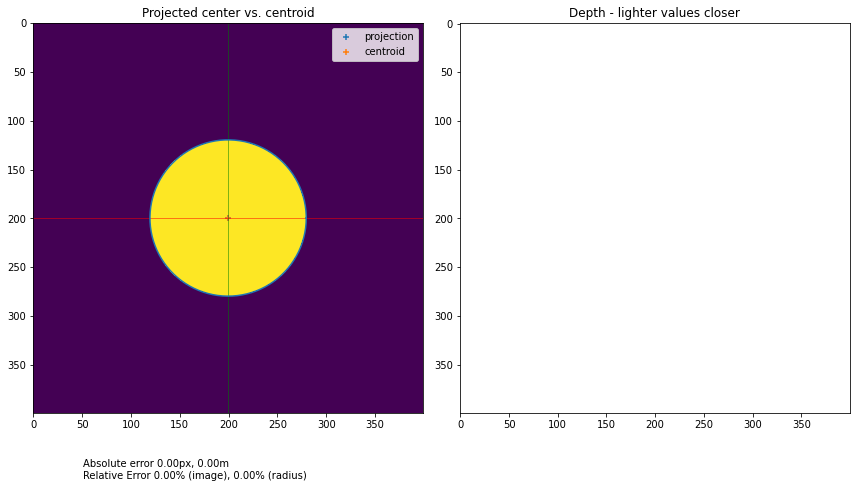

(0.0, 0.0)

In [148]:
# Center, no rotation
compute_circle_metrics(
    t_cam_plane=(
        T.translation_matrix([0.0, 0.0, 5.0])
        @ T.rotation_matrix(np.radians(0), [1.0, 0.0, 0.0])
    ),
    K=K,
    image_shape=(H, W),
    circle_radius=radius,
    plot=True,
    show=True,
    filename="centered-norot.png",
)

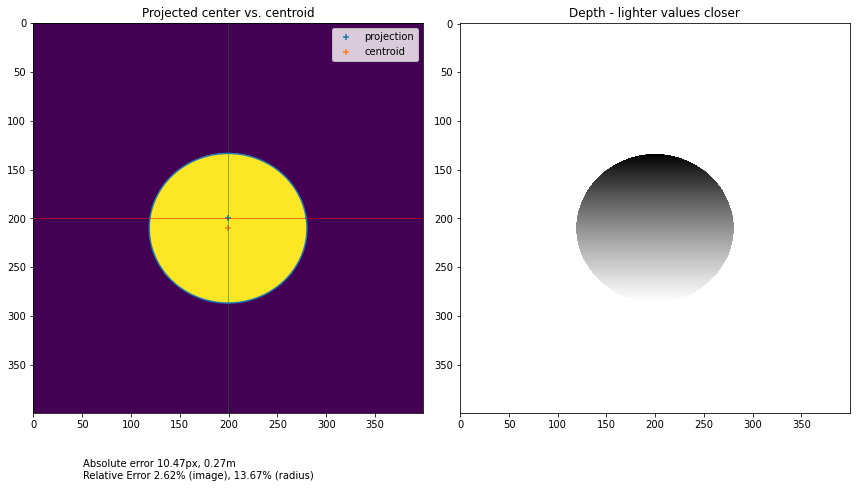

(10.472833916443705, 0.2734129495662721)

In [149]:
# Rotated arount x-axis and shifted down
compute_circle_metrics(
    t_cam_plane=(
        T.translation_matrix([0.0, 0.0, 5.0])
        @ T.rotation_matrix(np.radians(-20), [1.0, 0.0, 0.0])
    ),
    K=K,
    image_shape=(H, W),
    circle_radius=radius,
    plot=True,
    show=True,
    filename="down-rot20.png",
)

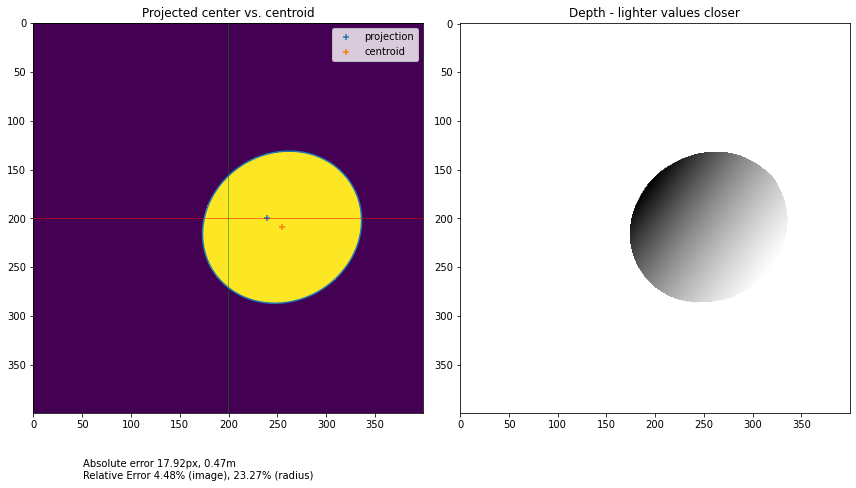

(17.91949639512709, 0.4654941102940844)

In [150]:
# rotate in two directions
compute_circle_metrics(
    t_cam_plane=(
        T.translation_matrix([1.0, 0.0, 5.0])
        @ T.rotation_matrix(np.radians(30), [0.0, 1.0, 0.0])
        @ T.rotation_matrix(np.radians(-20), [1.0, 0.0, 0.0])
    ),
    K=K,
    image_shape=(H, W),
    circle_radius=radius,
    plot=True,
    show=True,
    filename="down-rot20.png",
)

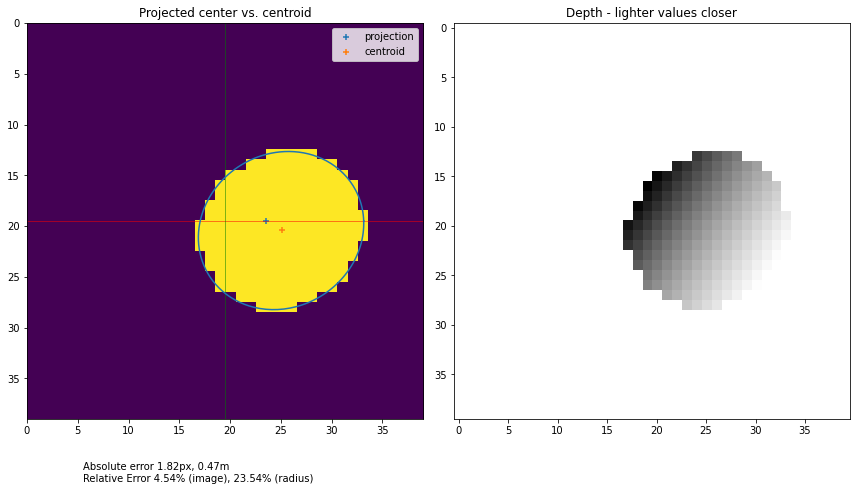

(1.8176472399979202, 0.470728768267817)

In [151]:
# Same as above, but less pixel
H, W = (40, 40)
K = np.array(
    [
        [0.5*W, 0, (W-1)*0.5],
        [0, 0.5*H, (H-1)*0.5],
        [0, 0, 1],
    ]
)
compute_circle_metrics(
    t_cam_plane=(
        T.translation_matrix([1.0, 0.0, 5.0])
        @ T.rotation_matrix(np.radians(30), [0.0, 1.0, 0.0])
        @ T.rotation_matrix(np.radians(-20), [1.0, 0.0, 0.0])
    ),
    K=K,
    image_shape=(H, W),
    circle_radius=radius,
    plot=True,
    show=True,
)